# Train model

1. 일반 vs 비정상 분류 모델
2. 비정상 분류 모델

#### class
```
- '일반 대화': 0
- '협박 대화': 1
- '갈취 대화': 2
- '직장 내 괴롭힘 대화': 3
- '기타 괴롭힘 대화': 4
```

#### text
- max length: 430
- min length: 100
- sep: \n (다른 발화자끼리)


#### 모델 리스트
- [DistilKoBERT](https://github.com/monologg/DistilKoBERT): pretrained korean embedding 존재하며, bert보다 빠름
- [kykim/bert-kor-base](https://teddylee777.github.io/huggingface/bert-kor-text-classification/): BERT 모델
- ~~[KcELECTRA: Korean comments ELECTRA](https://github.com/Beomi/KcELECTRA): 적은 용량, 계산 효율 Electra 모델~~
  - [tokenizer.json 한글인코딩 이슈](https://huggingface.co/beomi/KcELECTRA-base/discussions/6) 아래와 같은 인코딩 문제가 발생하여, 폐기
```py
pretrained_model = "beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
tokenizer.tokenize("[CLS] 나는 아침을 먹었다 [SEP]")
['[CLS]', 'ĠëĤĺëĬĶ', 'ĠìķĦì¹¨', 'ìĿĦ', 'Ġë¨¹ìĹĪëĭ¤', 'Ġ', '[SEP]']
```
- [monologg/koelectra-base-v3-discriminator](https://huggingface.co/monologg/koelectra-base-v3-discriminator): 또 다른 electra 모델 선정
  
  
#### Reference

1. [Huggingface text classification](https://huggingface.co/docs/transformers/tasks/sequence_classification)
2. [KoELECTRA v3](https://github.com/monologg/KoELECTRA/tree/master)


# 첫번째 모델
> 일반 vs 비정상 분류 모델

In [1]:
from tqdm.notebook import tqdm
tqdm.pandas()

import os
import pandas as pd
import tensorflow as tf

In [2]:
df = pd.read_csv("./minwook_data.csv")
df.head()

,class,text
0,1,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,1,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...
2,4,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...
3,2,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...
4,3,나 이틀뒤에 가나다 음식점 예약좀 해줘. 저녁7시로. 가나다 음식점이요.? 응. 남...


In [3]:
df.shape

(6820, 2)

In [6]:
# 비정상데이터 모두 1로 변환
df.loc[df['class'] !=0, 'class'] = 1

In [5]:
df.sample(15)

,class,text
4206,0,언니 김남욱 알아?\n김남욱 알지!\n그 사람 좀 통통했잖아 그런데 이번에 살 쫙 ...
3294,1,정 대리 박 과장이랑 잘해봐. 네? 제가요? 박 과장 사람도 참 괜찮고 부동산 관리...
4084,0,너네 낚시 여행도 자주 가겠다?\n내가 싫어함 그래서 안 감\n와 근데 잡네 잡는 ...
6632,0,예전에 주택 살 때 너희 집이랑 가까웠지?\n너무 가까웠죠! 이사 가서 너무 아쉬워...
3409,1,너 아이를 내가 데리고 있다. 죄송합니다 정말 한번만 봐주세요 제 귀한 자식입니다....
4836,0,너 롤토체스 해 봤어?\n너 칼바람만 하더니 갑자기 롤토체스는 왜?\n아니 핸드폰에...
2740,1,도저히 상황이 안돼서 말씀하신 기간까지 마련하지 못한 점 죄송하게 생각합니다. 그래...
2532,1,뭐해 ? 나 지금 새로 생긴 일 때문에 잠시 나왔지. 뭐? 너 그런 이야기 없었잖아...
3964,0,오늘 니 점심 뭐 먹었어?\n나 오늘 국수 먹을까 하다가 늦잠 자서 못 먹음\n아 ...
5233,0,우리 결혼식 치른 지 엊그제 같은데 벌써 애들이 결혼할 나이네\n벌써 우리 애들이 ...


# Tokenize

In [7]:
from transformers import ElectraTokenizer

pretrained_model = "monologg/koelectra-small-v3-discriminator"

tokenizer = ElectraTokenizer.from_pretrained(pretrained_model)

In [7]:
# from transformers import AutoTokenizer

# pretrained_model = "beomi/KcELECTRA-base"

# tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

In [8]:
# df = df.replace(r'\\n', tokenizer.sep_token, regex=True) # [SEP]
df = df.replace(r'\\n', '. ', regex=True) # .
assert df['text'].str.contains(r'\n').any() == False
df.sample(3)

,class,text
6327,0,헐 대박 숟가락으로 땅굴 파서 탈옥했대 키키. 헉 정말? 영화에서 보던 이야기였는데...
2258,1,00씨 커피좀 사와 저 지금 거래처 전화 기다리고 있어요 중요한건가 네 내가 받을테...
6576,0,서울은 버스비 어느 정도 해?. 나 버스 한 번도 안 타봐서 모르겠는데 지하철은 1...


In [9]:
tokenizer.decode(tokenizer.encode(df['text'][5084]))

'[CLS] 야야 피자 vs 치킨 과연 당신의 선택은?. 나는 피자랑 치킨 중에 하나만 고르라면 치킨!. 나는 피자가 더 맛있더라 키키. 아 그래? 나는 뭐랄까 치킨이 땡길 때가 많더라고. 그치 튀긴 건 원래 다 맛있잖아 키키. 인정 키키 튀긴 음식은 그냥 다 맛있는 듯. 너 튀김 중에 족발 튀김이라고 들어 봤어?. 그건 뭐야? 처음 들어 본다 그걸 튀겨?. 그냥 족발도 맛있는데 그걸 한 번 더 튀겼대. 오 신기하네 내가 족발을 자주 안 먹어서 그건 몰랐다. 나도 안 먹긴 한데 키키 그냥 튀김 생각나서 말해 봤어. 신기하네 키키 그거 바삭하긴 한가?. 응 껍질에서 소리 대박이야 키키. 헐 신기하네 키키 한번 먹어는 보고 싶다. 응 옆 동네에 새로 생겼다던대 가 볼래?. 오케이 콜 족발에 소주 한잔 ㄱㄱ [SEP]'

In [10]:
# # For showing number of UNK
# def tokenize(datas):
#     return tokenizer(datas["text"], truncation=True)

# dataset = Dataset.from_pandas(df)
# tokenized_dataset = dataset.map(tokenize, batched=True).to_pandas()

# unk_token_encoded = tokenizer.encode(tokenizer.unk_token)[0]

# def contains_unk_token(input_ids, unk_token_encoded):
#     return unk_token_encoded in input_ids

# cnt = tokenized_dataset['input_ids'].apply(lambda x: contains_unk_token(x, unk_token_encoded))
# print(f'UNKNOWN 토큰의 출현 횟수는 총 {cnt.sum()} 입니다.')

  0%|          | 0/7 [00:00<?, ?ba/s]

UNKNOWN 토큰의 출현 횟수는 총 6820 입니다.


In [10]:
def convert_to_input(df, tokenizer, max_length):
    input_ids = []
    attention_masks = []
    labels = []

    for i in range(len(df)):
        sentence = df.iloc[i]['text'].replace('.', '')
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        labels.append(df.iloc[i]['class'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks
    }, labels


# Data Split

In [11]:
from sklearn.model_selection import train_test_split

SEED = 1024
MAX_LENGTH = 250
BATCH_SIZE = 16

train_df, test_df = train_test_split(
    df, test_size = 0.2, random_state = SEED, stratify=df['class']
)
train_inputs, train_labels = convert_to_input(train_df, tokenizer, max_length=MAX_LENGTH)
test_inputs, test_labels = convert_to_input(test_df, tokenizer, max_length=MAX_LENGTH)
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels)).batch(BATCH_SIZE)

In [12]:
test_df.sample(5)

,class,text
3929,0,점심 식사는 했나? 키키. 엉 키키 엄청 이것저것 먹었어. 오 키키 나도 서남 시장...
6526,0,나 요즘에 운동하고 있엉!. 오~ 무슨 운동?. 나 신촌에서 알바 끝나고 집까지 걸...
4539,0,오빠~ 주말에 배드민턴 치러 갈까~?. 오~ 배드민턴! 재밌겠다 하하. 자기 잘 쳐...
2362,1,승연씨. 회사를 넘 편하게 다니는 거 아니야? 네? 그게 무슨 말씀이세요? 아니 승...
3534,0,캠핑 가고 싶노. 저는 최근에 한번 갔다 왔습니다 하하. 오~ 어디로 갔다 왔어?....


In [11]:
# tf.debugging.set_log_device_placement(True) # gpu check

> NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


    `TFElectraForSequenceClassification` 모델은 subclass형식의 모델이기 때문에, ModelCheckpoint에서 save할때 hdf5로 serialize를 안전하게 할 수 없는 것 같다. 'tf'형식으로 저장 또는 weight만 저장하도록 해줘야하는데, tf형식으로 저장하도록 ModelCheckpoint에 알릴 방법이 없는 것 같아, weight만 저장하도록 했다.

```py
callback_modelcheckpoint = ModelCheckpoint(
    ...
    save_weights_only="True"
)
```

## TFElectraForSequenceClassification

이 모델의 `num_labels == 1`이면 regression loss로 계산되고(`Mean-Square loss`), `config.num_labels > 1`이면 `Cross-Entropy`로 계산됩니다.

> If config.num_labels == 1 a regression loss is computed (Mean-Square loss), If config.num_labels > 1 a classification loss is computed (Cross-Entropy).

In [13]:
import re
from sklearn.preprocessing import LabelEncoder
from transformers import TFElectraForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


MODEL_NAME = 'koelectra-small-v3'
MODEL_CHECK_POINT_PATH = f"{MODEL_NAME}.weights.h5"
MODEL_SAVE_PATH = os.path.join("_model", MODEL_NAME)


callback_earlystopping = EarlyStopping(
    monitor="val_accuracy", min_delta=0.001, patience=3
)
# lr 조절
callback_learningrate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-6,
)

callback_modelcheckpoint = ModelCheckpoint(
    filepath=MODEL_CHECK_POINT_PATH,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only="True"
)
callbacks = [
    callback_earlystopping,
    callback_learningrate_scheduler,
    callback_modelcheckpoint,
]

EPOCHS = 50
# /device:GPU:0
with tf.device('/device:GPU:0'):
    model = TFElectraForSequenceClassification.from_pretrained(
        pretrained_model,
        num_labels=1,
        from_pt=True,  # Load from PyTorch checkpoint
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, 
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    history = model.fit(
        train_dataset, 
        epochs=EPOCHS, 
        validation_data=test_dataset,
        callbacks = callbacks,
    )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'electra.embeddings.position_ids']
- This IS expected if you are initializing TFElectraForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFElectraForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dens

Epoch 1/50
341/341 [==============================] - 88s 211ms/step - loss: 0.4690 - accuracy: 0.7769 - val_loss: 0.2291 - val_accuracy: 0.9993
Epoch 2/50
341/341 [==============================] - 69s 203ms/step - loss: 0.1518 - accuracy: 0.9956 - val_loss: 0.0726 - val_accuracy: 0.9993
Epoch 3/50
341/341 [==============================] - 69s 203ms/step - loss: 0.0528 - accuracy: 0.9996 - val_loss: 0.0502 - val_accuracy: 0.9919
Epoch 4/50
341/341 [==============================] - 69s 202ms/step - loss: 0.0255 - accuracy: 0.9993 - val_loss: 0.0139 - val_accuracy: 1.0000


In [14]:
if os.path.exists(MODEL_SAVE_PATH):
    print(f"{MODEL_SAVE_PATH} -- Folder already exists \n")
else:
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
    print(f"{MODEL_SAVE_PATH} -- Folder create complete \n")

# save tokenizer, model
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

_model/koelectra-small-v3 -- Folder create complete 



('_model/koelectra-small-v3/tokenizer_config.json',
 '_model/koelectra-small-v3/special_tokens_map.json',
 '_model/koelectra-small-v3/vocab.txt',
 '_model/koelectra-small-v3/added_tokens.json')

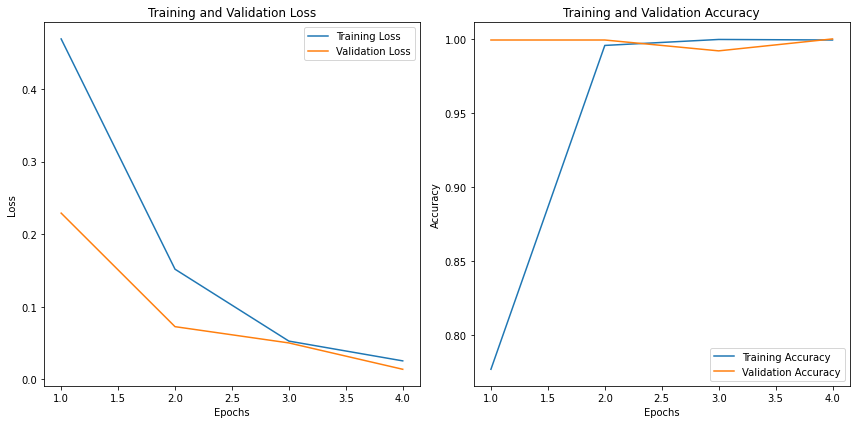

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 학습 기록 추출

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# 손실 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=loss, label='Training Loss')
sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=accuracy, label='Training Accuracy')
sns.lineplot(x=epochs, y=val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
from transformers import AutoTokenizer, TFElectraForSequenceClassification

loaded_tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)
loaded_model = TFElectraForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)


def evaluate(text: str, verbose=True):
    inputs = tokenizer(text, return_tensors="tf")
    logits = loaded_model(**inputs).logits
    probabilities = tf.nn.sigmoid(logits)
    # Apply threshold of 0.5 for binary classification
    class_id = tf.where(probabilities > 0.5, 1, 0).numpy()[0]
    return class_id

normal = df[df['class']==0].sample(10)
for _, row in normal.iterrows():
    print(evaluate(row['text']))

All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at _model/koelectra-small-v3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [17]:
최익현 = """
후임 형사 :(익현의 머리를 때리며) 이 새끼가 뭘 잘했다고, 앉아 마!
(곧바로 수갑찬 손으로 반격하며)씨빨놈이! 쳐 돌았나? 어데서 손을 함부로 놀리노? 느그 서장 어딨어! 강서장 델꼬와!! 니 내 누군줄 아나? 내가 이 새꺄! 느그 서장이랑 마! 개섀끼..
(선임 형사) :(급하게 달려오며) 저 서..선생님.. 실례지만 저희 서장님과 관계가 어떻게..
느그 서장 남천동 살제? 어?
(선임 형사) : 예.. 예..
내가 마! 느그 서장이랑 마! 어저께도! 어? 밥 묵고! 어? 사우나도 같이 가고! 어? 마 이 개이새꺄 마 다 했어! 이 새끼들이 말이야. 개섀끼들..
"""
print(evaluate(최익현))

아귀 = """
고광렬: 구땡입니다.
아귀: 어이, 고광렬이.
고광렬: 저 아세요?
아귀: 너는 첫 판부터 장난질이냐?(이와 동시에 바로 고광렬의 손목을 붙잡고 칼로 손등을 찍는다.)
고광렬: 흐그으으으으아아아아아앗
아귀: 니 손바닥에 화투 한 장 붙어 있다는 거에 내 돈 모두하고 내 손 하나를 걸겄다. 넌 무엇을 걸래~? 삼촌.
호구: ㅇ...예!
아귀: (고광렬의 손바닥에 칼로 꿰뚫린 화투를 보여주며) 이러니 돈을 꼴으셨제~
호구: 아...예...!
아귀: 해머 갖고 와.
아귀: 손 아까우면 다른 걸 걸어. 경상도 짝귀가 처음에...귀를 걸었던가? 으허허허
고광렬: 아...아귀...!
아귀: (호구에게) 잡어유.
고광렬: 한...한번만 봐주세요...!
아귀: 흐흐흐흐 너 다음은 고니 차례여.
"""

print(evaluate(아귀))

일반글 = """
흔한 커플의 카톡 대화 을 클릭해보았다.이게 웬걸 ㅋㅋ 웃기다 ㅋㅋ 

흔한 커플의 대화긴 하다.ㅋㅋ 흔한 커플의 카톡 대화 에서 보듯 ㅋㅋ 사귀다보면 ㅋㅋ 문자도 짧아진다 ㅋ

사랑한다는 말또한 줄어든다.ㅋㅋ 그건 당연한것이 아닌가?ㅋㅋ 저는 ㅋㅋ 그런말 하지도 않습니다.ㅋ

사랑은 하는데 ㅋㅋ 그런말을 못하겠더라구요 ㅋ 그래서 여자친구가 ㅋㅋ 좀 뭐라고 하지요.ㅋ

일반 커플도 다 그렇지 않나요??ㅋㅋ 사귀다 결혼해도 사귈때랑 같고. ㅋㅋ

그냥 그런게 사람 사는거 아니겠습니까??ㅋㅋㅋ 흔한 커플의 카톡 대화 에서 보니 ㅋㅋ

저 같은 사람 많더라구요.ㅎㅎ 그럼 한번 알아볼까요??ㅎㅎ

그리고 ㅋㅋ 한번 본인의 상태도 점검해 보시길 바랍니다.ㅋㅋ
"""
print(evaluate(일반글))

[1]
[1]
[0]


# 회고

1. accuracy 0.76에서 갑자기 validation이 1에 근사한 이유가 궁금하다.
2. [SEP]를 지우고 하니 잘되는 이유가 궁금하다.